### Newsgroup Classification with NB and SVM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import nltk

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import sem
from nltk.corpus import stopwords

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Fetching the entire 20 Newsgroups dataset
news = fetch_20newsgroups(subset = 'all')

# Selecting the first 3000 data samples
n_samples = 3000
X = news.data[:n_samples]
y = news.target[:n_samples]

In [3]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 11)

In [4]:
nltk.download('stopwords') # Downloading the stopwords dataset from NLTK
stops = (stopwords.words('english')) # Storing the English stopwords
stop_words = list(stops) # Converting the stopwords object to a list

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wodnj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Initialize the TfidfVectorizer
tfidf = TfidfVectorizer(stop_words = stop_words, token_pattern = r"\b[a-z0-9_\-\.]+[a-z][a-z0-9_\-\.]+\b", norm = None)

# Fit the TfidfVectorizer and transform into a TF-IDF matrix
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(X_train_tfidf.shape )
print(X_test_tfidf.shape)

(2400, 51043)
(600, 51043)


---
Classification with Multinomial Naive Bayes

In [6]:
# Define the pipeline
clf = Pipeline([('vect', TfidfVectorizer(stop_words = stop_words, token_pattern = r"\b[a-z0-9_\-\.]+[a-z][a-z0-9_\-\.]+\b",)),
                ('nb', MultinomialNB(alpha = 0.01)),])

In [7]:
def evaluate_cross_validation(clf, X, y, K):

    cv = KFold(n_splits = K, random_state = 0, shuffle = True) # Create a KFold cross-validation object with K splits
    scores = cross_val_score(clf, X, y, cv = cv) # Perform cross-validation

    print(scores)
    print("Mean score: %.3f (+/-%.3f)" % (np.mean(scores), sem(scores)))

In [8]:
evaluate_cross_validation(clf, X_train, y_train, 5)

[0.81041667 0.80833333 0.81458333 0.79583333 0.80833333]
Mean score: 0.807 (+/-0.003)


In [9]:
def calc_params(X, y, clf, param_values, param_name, K):
    
    # Convert input data to Numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Initialize arrays to store the training and testing scores
    train_scores = np.zeros(len(param_values))
    test_scores = np.zeros(len(param_values))
    
    for i, param_value in enumerate(param_values):

        # Set the current parameter value in the classifier's parameters
        clf.set_params(**{param_name:param_value}) 
        
        # Initialize arrays to store the K-fold scores
        k_train_scores = np.zeros(K)
        k_test_scores = np.zeros(K)
        
        # Set up KFold cross-validation with K splits
        cv = KFold(n_splits = K, shuffle = True, random_state = 0)
        
        # Perform cross-validation for K folds
        j = 0

        for train, test in cv.split(X):

            # Fit the model
            clf.fit(X[train], y[train])

            # Evaluate training and testing sets
            k_train_scores[j] = clf.score(X[train], y[train])
            k_test_scores[j] = clf.score(X[test], y[test])

            j += 1
            
        # Calculate and store the mean score
        train_scores[i] = np.mean(k_train_scores)
        test_scores[i] = np.mean(k_test_scores)
        print(param_name, '=', param_value, "/", "Train =", train_scores[i], "/", "Test =", test_scores[i])
       
    # Plot the training and testing scores against the parameter values
    plt.semilogx(param_values, train_scores, label = 'Train', alpha = 0.4, lw = 2, c = 'b')
    plt.semilogx(param_values, test_scores, label = 'X-Val', alpha = 0.4, lw = 2, c = 'g')
    plt.legend(loc = 7)
    plt.xlabel(param_name + " values")
    plt.ylabel("Mean cross validation accuracy")

    return train_scores, test_scores

nb__alpha = 1e-07 / Train = 1.0 / Test = 0.7641666666666665
nb__alpha = 5.994842503189409e-07 / Train = 1.0 / Test = 0.76875
nb__alpha = 3.5938136638046257e-06 / Train = 1.0 / Test = 0.77625
nb__alpha = 2.1544346900318867e-05 / Train = 1.0 / Test = 0.7825
nb__alpha = 0.0001291549665014884 / Train = 1.0 / Test = 0.7875
nb__alpha = 0.000774263682681127 / Train = 1.0 / Test = 0.7970833333333334
nb__alpha = 0.004641588833612782 / Train = 1.0 / Test = 0.8066666666666669
nb__alpha = 0.02782559402207126 / Train = 0.9992708333333333 / Test = 0.8020833333333334
nb__alpha = 0.1668100537200059 / Train = 0.9938541666666666 / Test = 0.77625
nb__alpha = 1.0 / Train = 0.9670833333333334 / Test = 0.6975


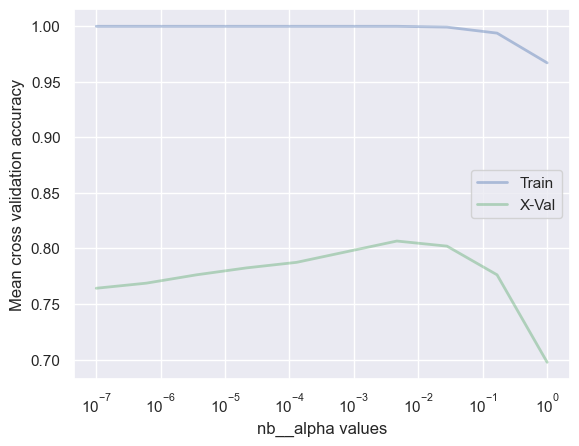

In [10]:
# Call the calc_params function to evaluate the performance of the classifier
alphas = np.logspace(-7, 0, 10)
train_scores, test_scores = calc_params(X_train, y_train, clf, alphas, 'nb__alpha', 5)

In [11]:
mnb = MultinomialNB(alpha = 0.04) # Initialize a Multinomial Naive Bayes classifier with the optimum value of alpha
mnb.fit(X_train_tfidf, y_train) # Train the model
mnb_pred = mnb.predict(X_test_tfidf) # Make predictions

In [12]:
# Print the classification report
print(classification_report(mnb_pred, y_test, target_names = news.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.81      0.92      0.86        24
           comp.graphics       0.69      0.83      0.76        30
 comp.os.ms-windows.misc       0.26      0.91      0.40        11
comp.sys.ibm.pc.hardware       0.63      0.46      0.54        41
   comp.sys.mac.hardware       0.77      0.59      0.67        39
          comp.windows.x       0.81      0.72      0.76        36
            misc.forsale       0.55      0.77      0.64        22
               rec.autos       0.81      0.81      0.81        21
         rec.motorcycles       0.86      0.94      0.90        32
      rec.sport.baseball       0.96      0.93      0.95        28
        rec.sport.hockey       1.00      0.91      0.95        34
               sci.crypt       0.83      0.74      0.78        34
         sci.electronics       0.79      0.69      0.74        49
                 sci.med       0.88      0.88      0.88        25
         

---
Classification with Support Vector Machine - linear

In [13]:
# Define the pipeline
clf = Pipeline([('vect', TfidfVectorizer(stop_words = stop_words, token_pattern = r"\b[a-z0-9_\-\.]+[a-z][a-z0-9_\-\.]+\b",)),
                ('svc', SVC(kernel = 'linear')),])

In [14]:
evaluate_cross_validation(clf, X_train, y_train, 5)

[0.8        0.80833333 0.83333333 0.79375    0.79375   ]
Mean score: 0.806 (+/-0.007)


svc__C = 1 / Train = 0.9973958333333333 / Test = 0.8058333333333334
svc__C = 5 / Train = 1.0 / Test = 0.8099999999999999
svc__C = 10 / Train = 1.0 / Test = 0.8099999999999999
svc__C = 50 / Train = 1.0 / Test = 0.8099999999999999
svc__C = 100 / Train = 1.0 / Test = 0.8099999999999999


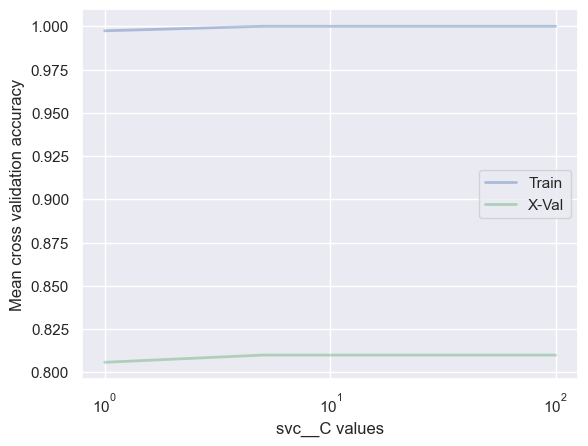

In [15]:
# Call the calc_params function to evaluate the performance of the classifier
c_vals = [1, 5, 10, 50, 100]
train_scores, test_scores = calc_params(X_train, y_train, clf, c_vals, 'svc__C', 5)

---
Classification with Support Vector Machine - rbf

In [16]:
# Define a dictionary that contains the hyperparameter search space
parameters = {'svc__gamma': np.logspace(-3, 0, 4),
              'svc__C': [1, 10, 100],}

In [17]:
# Define the pipeline
clf = Pipeline([('vect', TfidfVectorizer(stop_words = stop_words, token_pattern = r"\b[a-z0-9_\-\.]+[a-z][a-z0-9_\-\.]+\b",)),
                ('svc', SVC(kernel = 'rbf')),])

In [18]:
gs = GridSearchCV(clf, parameters, verbose = 2, cv = 3) # Perform Grid Search Cross Validation
gs.fit(X, y) # Fit the GridSearchCV object to the data
gs.best_params_, gs.best_score_ # Extract the best hyperparameter values

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END .........................svc__C=1, svc__gamma=0.001; total time=  10.4s
[CV] END .........................svc__C=1, svc__gamma=0.001; total time=   9.8s
[CV] END .........................svc__C=1, svc__gamma=0.001; total time=  10.0s
[CV] END ..........................svc__C=1, svc__gamma=0.01; total time=  10.0s
[CV] END ..........................svc__C=1, svc__gamma=0.01; total time=  10.1s
[CV] END ..........................svc__C=1, svc__gamma=0.01; total time=  10.0s
[CV] END ...........................svc__C=1, svc__gamma=0.1; total time=  10.0s
[CV] END ...........................svc__C=1, svc__gamma=0.1; total time=  10.1s
[CV] END ...........................svc__C=1, svc__gamma=0.1; total time=  10.1s
[CV] END ...........................svc__C=1, svc__gamma=1.0; total time=  10.2s
[CV] END ...........................svc__C=1, svc__gamma=1.0; total time=  10.3s
[CV] END ...........................svc__C=1, sv

({'svc__C': 100, 'svc__gamma': 0.1}, 0.8253333333333334)

In [19]:
# Define the pipeline
clf = Pipeline([('vect', TfidfVectorizer(stop_words = stop_words, token_pattern = r"\b[a-z0-9_\-\.]+[a-z][a-z0-9_\-\.]+\b",)),
                ('svc', SVC(kernel = 'rbf', C = 100, gamma = 0.1)),])

clf.fit(X_train, y_train) # Fit the model
svc_pred = clf.predict(X_test) # Make predictions 
print(clf.score(X_test, y_test))

0.845


In [20]:
# Print the classification report
print(classification_report(svc_pred, y_test, target_names = news.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.81      0.92      0.86        24
           comp.graphics       0.86      0.78      0.82        40
 comp.os.ms-windows.misc       0.90      0.85      0.88        41
comp.sys.ibm.pc.hardware       0.67      0.83      0.74        24
   comp.sys.mac.hardware       0.90      0.79      0.84        34
          comp.windows.x       0.88      0.85      0.86        33
            misc.forsale       0.77      0.92      0.84        26
               rec.autos       0.71      0.71      0.71        21
         rec.motorcycles       0.91      0.89      0.90        36
      rec.sport.baseball       0.81      0.96      0.88        23
        rec.sport.hockey       0.97      0.91      0.94        33
               sci.crypt       0.80      0.96      0.87        25
         sci.electronics       0.86      0.79      0.82        47
                 sci.med       0.92      0.74      0.82        31
         

Text(67.24999999999999, 0.5, 'predicted label')

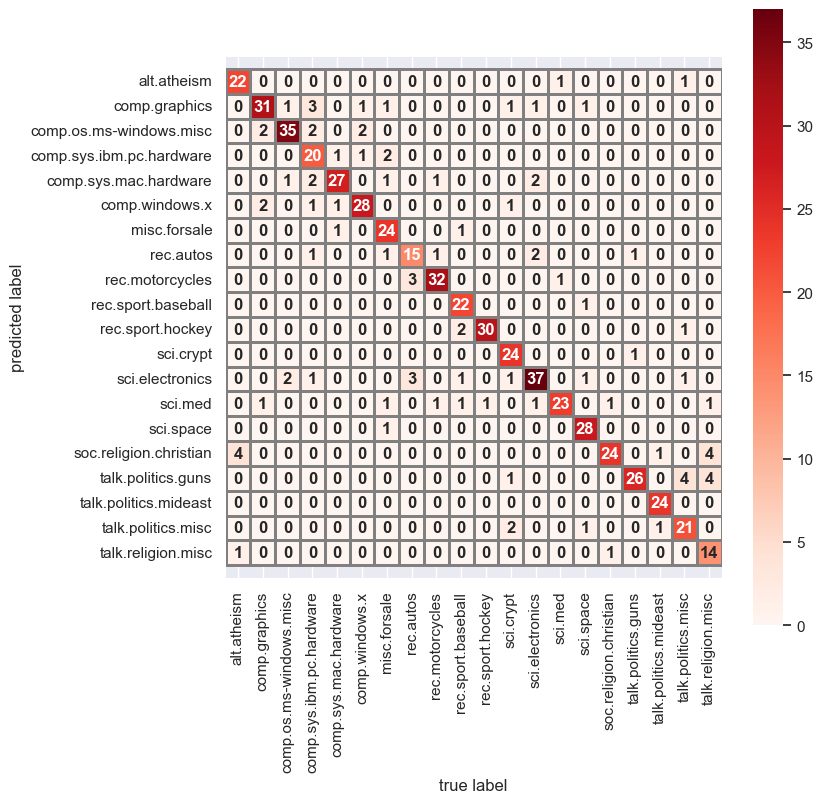

In [21]:
# Create the confusion matrix
mat = confusion_matrix(y_test, svc_pred)

# Create a figure and axis for the heatmap
fig, ax = plt.subplots(figsize = (8, 8))

# Plot the heatmap
ax = sns.heatmap(mat.T,
                 square = True, 
                 linecolor = 'grey', 
                 linewidths = 1, 
                 annot = True,
                 fmt = 'd',
                 cbar = True,
                 cmap = 'Reds', 
                 ax = ax, 
                 annot_kws = {"fontsize": 12, "weight": "bold"},
                 xticklabels = news.target_names,
                 yticklabels = news.target_names)

# Adjust the y-axis
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

# Set the labels for the axes
plt.xlabel('true label')
plt.ylabel('predicted label')